In [ ]:
# Add module to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Imports
from aoc23.utils import read_input
from collections import namedtuple
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
input_21 = read_input(21)

## Part 1

In part 1 of the [day 21 puzzle](https://adventofcode.com/2023/day/21), we are given a map of a garden, in the form of a $2\times 2$ array, consisting of the following tiles:
- `S` = starting position,
- `.` = garden plots,
- `#` = rocks.

At each time step, we can step in one of the four cardinal directions, provided that there is not a rock there blocking our path (the starting position `S` counts as a garden plot). The main task for both parts of this puzzle is determining the total number of accessible tiles after $n>0$ steps from `S`.

Each plot can be represented as a named tuple, with `row` and `col` attributes:

In [4]:
Plot = namedtuple('Plot', ['row', 'col'])

The class `PlotCalculator` collects together some useful functions, which can be used to find the total number of accessible steps:

- `find_starting_plot`: finds the position of the starting tile `S` within the array
- `neighbouring_plots`: for a given plot, find the plots that neighbour it (i.e. lay in the grid, and do not contain a rock).
- `compute_visited_plots`: given a number of steps to take $n$, finds all the plots that can be reached with exactly $n$ steps. At each step, find the new plots that can be accessed by taking an additional step.
- `visualise_visit`: visualize the plots found after $n$ steps by marking them with an `O`.

A key observation is that any plot visited on step $k$ can also be visited on step $k+2m$ for any $m>0$. This is because once a plot is visited, it can be revisited $2$ steps later by stepping back to the previous plot, and then stepping forward again; repeat this $m$ times to visit it on step $k+2m$.

Therefore, the record of accessible plots can be divided into $2$ groups - those reachable with an even number of steps, and those reachable with an odd number of steps. Each of these groups grows in a cumulative fashion - a plot is never removed from the group, only ever added. Also, we need only track the plots on the boundary of the outwardly-growing collection of visited tiles for each step parity (i.e. those found by taking the previous step). This greatly decreases the amount of plots that need to be checked at each stage.

In [5]:
class PlotCalculator:

    def __init__(self, grid):
        self.grid = grid
        self.n_rows = len(grid)
        self.n_cols = len(grid[0])
    
    def find_starting_plot(self):
        for i, line in enumerate(self.grid):
            if 'S' in line:
                return (i, line.index('S'))

    def neighbouring_plots(self, plot):
        neighbour_plots = []
        
        # Step in one of the cardinal directions
        new_plots = [Plot(row=plot.row - 1, col=plot.col),
                     Plot(row=plot.row + 1, col=plot.col),
                     Plot(row=plot.row, col=plot.col - 1),
                     Plot(row=plot.row, col=plot.col + 1)]
        
        # Only accept steps inside the grid
        # and onto garden plots (not rocks)
        for new_plot in new_plots:
            if 0 <= new_plot.row < self.n_rows and 0 <= new_plot.col < self.n_cols:
                if self.grid[new_plot.row][new_plot.col] != '#':
                    neighbour_plots.append(new_plot)
                    
        return neighbour_plots

    
    def compute_visited_plots(self, n_steps):
        # Identify starting tile
        start_row, start_col = self.find_starting_plot()
        
        # Initialize odd/even parity visited tile dicts
        cumulative_plots = 1
        visited_plots = {0: {Plot(start_row, start_col): 1},
                         1: {}}
        outer_plots = {Plot(start_row, start_col): 1}
        
        # Take steps
        for i in range(1, n_steps+1):
            new_plots = {}
            step_parity = i % 2
            
            # Loop over all boundary plots
            for plot in outer_plots:
                
                # Find new neighbours
                neighbours = self.neighbouring_plots(plot)
                
                for neighbour in neighbours:
                    if neighbour not in visited_plots[step_parity]:
                        # Keep track of newly visited plots
                        new_plots[neighbour] = 1
                        visited_plots[step_parity][neighbour] = 1
            
            # Only need to look at boundary plots in next loop
            outer_plots = new_plots
        
        # Return plots with relevant step parity
        final_step_parity = n_steps % 2
        return visited_plots[final_step_parity]

    
    def visualise_visit(self, n_steps):
        visited = self.compute_visited_plots(n_steps)
        vis_grid = deepcopy(self.grid)
        
        # Replace all visited plots with 'O'
        for plot in visited.keys():
            old_row = vis_grid[plot.row]
            vis_grid[plot.row] = old_row[:plot.col] + 'O' + old_row[plot.col+1:]
            
        return vis_grid

To test this out, let's recreate the test array provided by the puzzle, and visualize the first few steps taken:

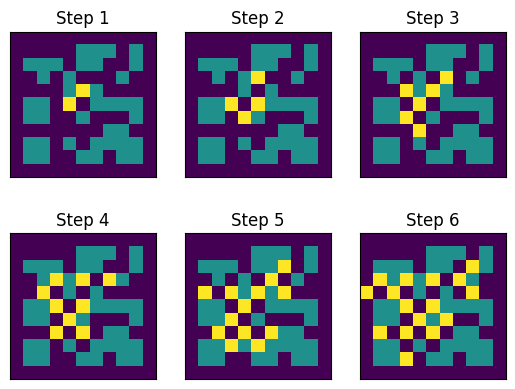

In [6]:
test_grid = [
    '...........',
    '.....###.#.',
    '.###.##..#.',
    '..#.#...#..',
    '....#.#....',
    '.##..S####.',
    '.##..#...#.',
    '.......##..',
    '.##.#.####.',
    '.##..##.##.',
    '...........'
]

pc_test = PlotCalculator(test_grid)

fig, ax = plt.subplots(nrows=2, ncols=3)
for i in range(6):
    row, col = i//3, i%3
    ax[row, col].matshow(
        np.array([[int(char.replace('.', '0').replace('#', '1').replace('O', '2').replace('S', '0')) for char in line] 
                  for line in pc_test.visualise_visit(i+1)])
    )
    ax[row, col].set_title(f'Step {i+1}')
    ax[row, col].get_xaxis().set_ticks([])
    ax[row, col].get_yaxis().set_ticks([])

The range of accessible plots is shown to be spreading out from the central `S` plot, and as expected each grid of matching step parity always includes the previously visited set of plots. 

The total number of visited tiles after 6 steps can be counted on the final grid above, or obtained directly from `compute_visited_plots`:

In [7]:
assert len(pc_test.compute_visited_plots(6)) == 16
print('Success!')

Success!


And so defining a new `PlotCalculator` for the full input grid, we can find the total number of visited states after $64$ steps:

In [8]:
pc = PlotCalculator(input_21)
len(pc.compute_visited_plots(64))

3637

So the answer to part 1 is: __3637__.

## Part 2

In the second part of the puzzle, we are told that the garden is in fact infinite in size - the provided map shows only one tile of the full garden, which repeats forever in every direction. Also, we are asked to find the number of accessible plots after not $64$, but $26501365$ steps.

First, the `PlotCalculator` class needs to be modified, to allow the rows and columns of the visited plots to lie outside of the original grid; also, when outside the grid, we should check for the presence of rocks by translating back to the original grid indices:

In [9]:
class InfinitePlotCalculator(PlotCalculator):
    
    def neighbouring_plots(self, plot):
        neighbour_plots = []
        
        # Step in one of the cardinal directions
        new_plots = [Plot(row=plot.row - 1, col=plot.col),
                     Plot(row=plot.row + 1, col=plot.col),
                     Plot(row=plot.row, col=plot.col - 1),
                     Plot(row=plot.row, col=plot.col + 1)]
        
        # Only accept steps onto garden plots (not rocks)
        for new_plot in new_plots:
            row = new_plot.row % self.n_rows
            col = new_plot.col % self.n_cols
            if self.grid[row][col] != '#':
                neighbour_plots.append(new_plot)
                    
        return neighbour_plots
    
    def visualise_visit(self, n_steps, **fig_args):
        assert self.n_rows == self.n_cols
        visited = self.compute_visited_plots(n_steps)

        n = max(0, (n_steps + self.n_rows//2) // self.n_rows)
        grid = np.tile([[int(char.replace('.', '0').replace('#', '1').replace('S', '0')) for char in row] for row in ipc.grid], 
                         (2*n+1, 2*n+1))

        for plot in visited:
            grid[plot.row + n*self.n_rows, plot.col + n*self.n_cols] = 2

        fig, ax = plt.subplots(**fig_args)
        ax.matshow(grid)
        ax.set_title(f'Step {n_steps}')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        return fig, ax

Once these changes are made, the results on the test grid match what is expected:

In [10]:
ipc_test = InfinitePlotCalculator(test_grid)

In [11]:
assert len(ipc_test.compute_visited_plots(6)) == 16
assert len(ipc_test.compute_visited_plots(10)) == 50
assert len(ipc_test.compute_visited_plots(50)) == 1594
assert len(ipc_test.compute_visited_plots(100)) == 6536
assert len(ipc_test.compute_visited_plots(500)) == 167004
assert len(ipc_test.compute_visited_plots(1000)) == 668697
print('Success!')

Success!


However, computing these values by brute force is clearly not feasible for 26 million steps - even for only 1000 steps, it is taking more that 16 seconds to compute:

In [12]:
%timeit len(ipc_test.compute_visited_plots(1000)) # 668697

6.6 s ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There are obvious optimizations that could be made in the code, but these are unlikely to allow the brute force computation of 26 million steps in a reasonable amount of time. This suggests that there is a way of computing the number of accessible plots without brute force.

Consider the infinite grid, consisting of tiles of the full $131\times 131$ array. The row and column containing the `S` tile are both free from rocks, so after $65$ steps the boundary of the visited region will reach all of the edges of the initial tile. In fact, by visualising the visited plots after $65$ steps, we see that all of the plots along the diagonals connecting these edge points are also completely visited:

(<Figure size 1000x1000 with 1 Axes>, <Axes: title={'center': 'Step 65'}>)

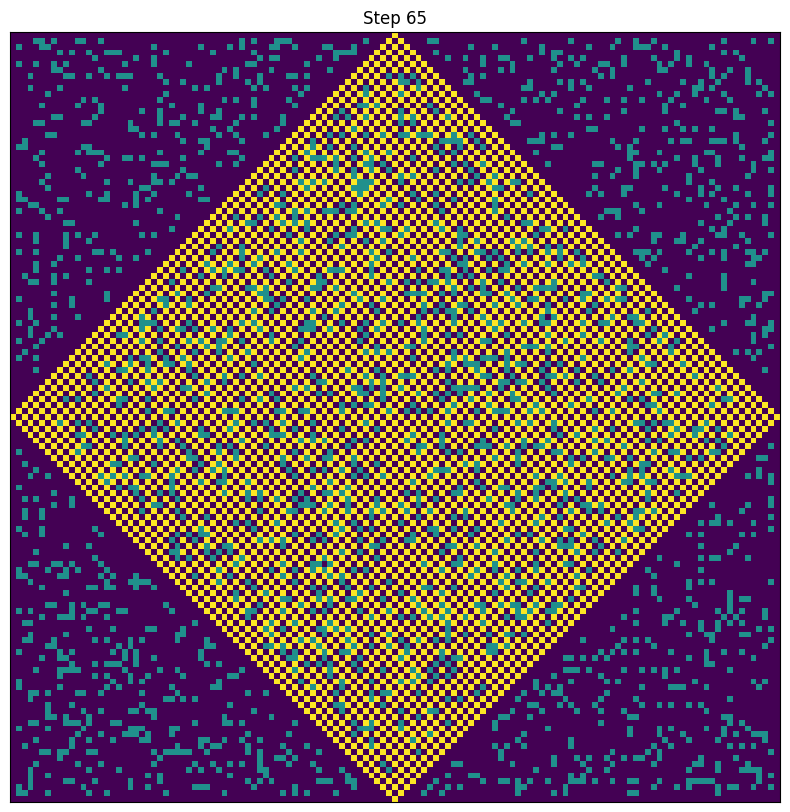

In [13]:
ipc = InfinitePlotCalculator(input_21)
ipc.visualise_visit(65, figsize=(10, 10))

The infinite tiling of these grids now becomes relevant - the boundary of the visited region will continue to spread outwards, over the diamond-like regions formed by the neighbouring tiles. It will take a further 131 steps (the height/width of the grid) to reach the edge of the immediately neighbouring tiles:

(<Figure size 2000x2000 with 1 Axes>, <Axes: title={'center': 'Step 196'}>)

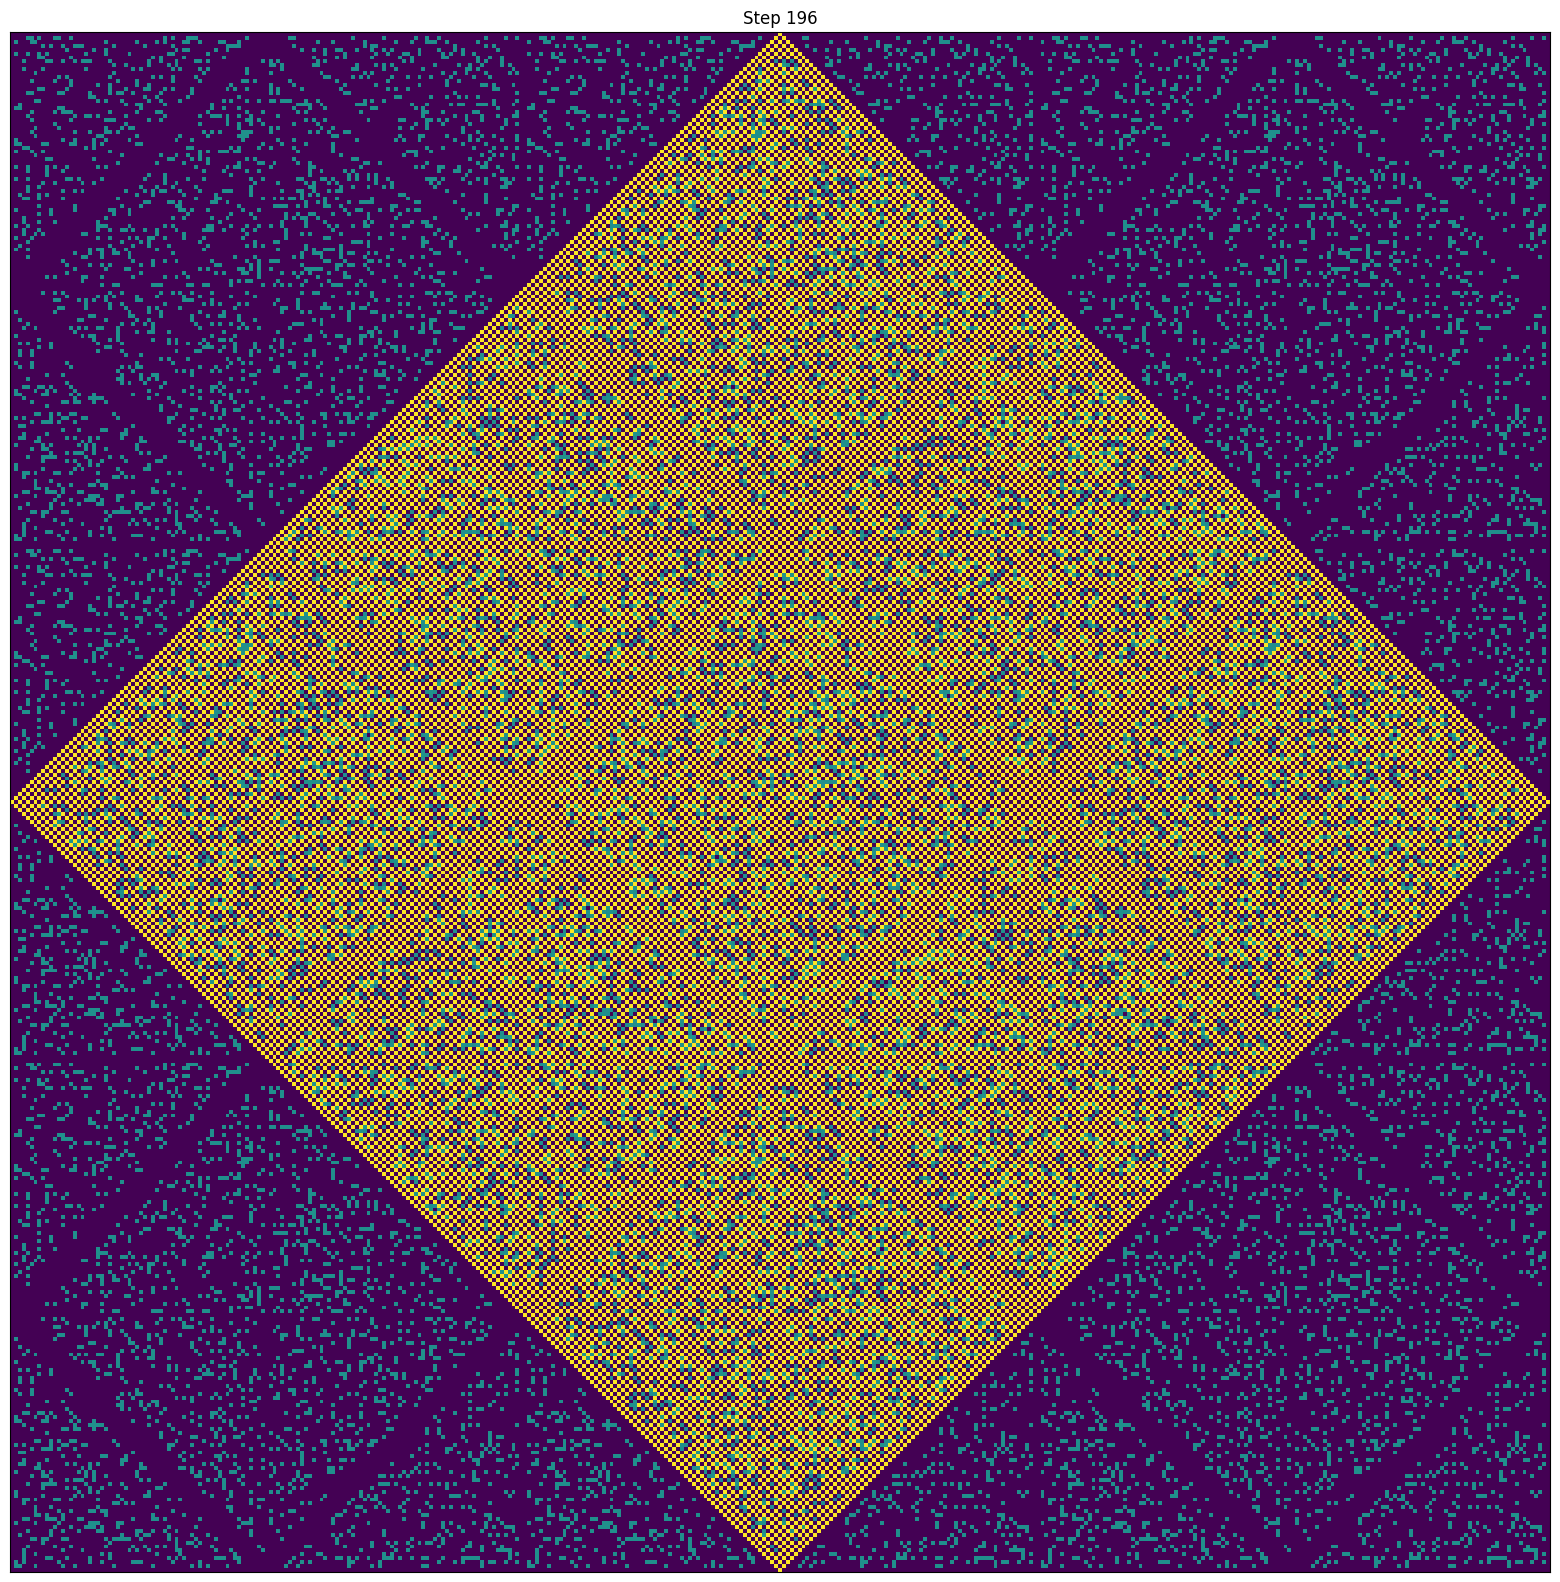

In [14]:
ipc.visualise_visit(65+131, figsize=(20, 20))

We see again that all the plots along the diagonals connecting the centres of the edges of the enlarged area are visited. After a further 131 steps, we again reach a similar state, one further tile out from the centre in each direction. Note that the total number of steps we are required to consider ($26501365$) is of the form $65 + 131n$ - in this case, $n=202300$:

In [15]:
assert (26501365 - 65) % 131 == 0
(26501365 - 65) // 131

202300

Therefore, if a relationship can be found between the number of steps in the form $65+131n$ and the total number of plots accessible using this number of steps, it can be used to find the required answer. Let's take a look at the first few numbers of accessible states, for step numbers of this form:

In [16]:
lengths = [len(ipc.compute_visited_plots(65 + 131*n)) for n in range(6)]
lengths

[3699, 33137, 91951, 180141, 297707, 444649]

Define $p(n)$ to be the number of accessible states after $65+131n$ steps. The key observation to make is that $p(n)$ is quadratic in n - this can be confirmed by looking at the second differences of the terms computed above:

In [17]:
np.diff(np.diff(lengths))

array([29376, 29376, 29376, 29376])

Why should we expect the function $p(n)$ to be quadratic? Take one more look at the original tile, formed by the provided array:

(<Figure size 1000x1000 with 1 Axes>, <Axes: title={'center': 'Step 0'}>)

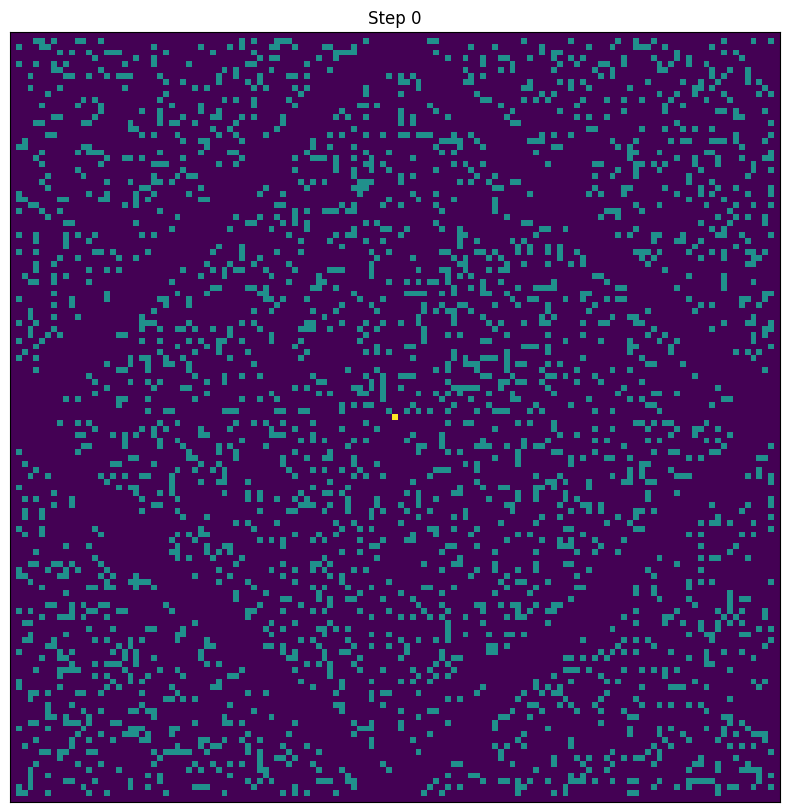

In [18]:
ipc.visualise_visit(0, figsize=(10, 10))

There is a clear central diamond shape (call this region A), which is completely cleared after the initial 65 steps. The four triangular corner pieces, when matched with corresponding neighbouring tiles, form another diamond shape (call this region B), with a different pattern of rocks to region A. The way that the tiles are combined in each direction create an alternating pattern of diamond shape A and B regions, which completely cover the plane:

![Tiles](day21_tiles.png)

After $65$ steps, just the central region $A$ is covered. After a further $131$ steps, a total of $5$ $A$ regions and $4$ $B$ regions are covered. After another $131$ steps, there are $13$ $A$ regions, and $12$ $B$ regions covered. After each additional multiple of $131$ steps, the number of $A$ and $B$ regions added increases linearly. In other words, the second difference in the number of $A$ and $B$ regions covered after each additional multiple of $131$ steps is constant ($4$ $A$ and $4$ $B$ regions).

In fact, it is slightly more subtle than this - when each $A$ or $B$ region is filled after $65+131n$ steps, each region can either have an even or an odd parity, depending on its position in the tiling. The parity of the region is related to the parity of the indices of the visited plots in the region, after $65+131n$ steps. For example, when the central $A$ region has an even parity, the neighbouring $A$ regions must have an odd parity, as it took an additional step to reach them from the central $A$ region. Similarly, neighbouring $B$ regions have opposite parity. So when we add an additional $4$ $A$ and $4$ $B$ regions to the difference, we should actually note that this is $2$ of each of the different parity versions of the regions $A$ and $B$.

The upshot of this observation is as follows: the second difference of the number of accessible plots is given by the sum of:
- twice the number of accessible plots in region $A$, with a even step parity,
- twice the number of accessible plots in region $A$, with a odd step parity,
- twice the number of accessible plots in region $B$, with a even step parity,
- twice the number of accessible plots in region $B$, with a odd step parity.

But the sum of the first and third of these is just twice the total number of accessible plots in region the original map tile, for an arbitrary even number of steps; likewise, the sum of the second and fourth is twice the total number of accessible plots in the original map tile after an arbitrary odd number of steps. We can use the original `PlotCalculator` to compute these, taking an sufficiently large number of steps to ensure the entire map has been visited:

In [19]:
2*(len(pc.compute_visited_plots(200)) + len(pc.compute_visited_plots(201)))

29376

So for each additional $131$ steps, the second difference in the number of accessible plots is constant, and equal to $29376$. This is exactly what we observed earlier, when comparing the directly computed values! Therefore, the total number of accessible plots must be quadratic in $n$, with the coefficient of the leading term equal to half of the second difference. Noting also that when $n=0$ we observed $3699$ visited plots, the formula for an arbitrary $n$ must take the form:

$$
p(n) = 14688n^2 + bn + 3699.
$$

where $p(n)$ is the number of accessible plots after $65+131n$ steps, and for some $b>0$. This final parameter can be deduced from the difference between $p(1)$ and $p(0)$, using the above formula:

$$
\begin{align}
b &= p(1) - p(0) - 14688 \\
&= 33137-3699-14688 \\
&= 14750.
\end{align}
$$

giving the final formula:
 
$$
p(n) = 14688n^2 + 14750n + 3699.
$$

Before using this formula to compute the final answer, here is another way to find this closed form expression for $p(n)$: instead of determing the coefficients of the quadratic using the properties of the grid, note that as we have $3$ explicit values of the number of accessible states for $3$ different $n$ values (by computing directly using `InfinitePlotCalculator`), the quadratic is already uniquely defined. Of course, using this method, the validity of a quadratic closed form expression is assumed, rather than deduced as in the previous argument. Ignoring what we know already about the coefficients, define generating quadratic $p(n)$ in the following way:

$$
p(n) = an^2 + bn + c,
$$

for $a, b, c\in\mathbb{R}$. We know that $p(0) = 3699$, $p(1) = 33137$, and $p(2) = 91951$, from our explicit computations earlier. This is sufficient information to set up a linear set of equations, of the form $A\mathbf{x} = \mathbf{b}$:

$$
\begin{pmatrix}
0 & 0 & 1 \\
1 & 1 & 1 \\
4 & 2 & 1
\end{pmatrix}
\begin{pmatrix}
a\\
b\\
c
\end{pmatrix}
=\begin{pmatrix}
3699\\
33137\\
91951
\end{pmatrix}.
$$

Inverting this equation allows us to find the coefficients of the quadratic:

In [20]:
A = [
    [0, 0, 1],
    [1, 1, 1],
    [4, 2, 1],
]

b = [3699, 33137, 91951]

# Solution = inv(A) * b
np.matmul(np.linalg.inv(A), b)

array([14688., 14750.,  3699.])

These coefficients match exactly with what we found earlier! With the quadratic fully determined, any number of steps of the form $65+131n$ for $n>0$ can be plugged into the formula, to obtain the total number of accessible states:

In [21]:
def visited_65_plus_131n(n):
    return 14688*n*n + 14750*n + 3699

With the value of $n$ found earlier, we can find the total number of visited plots after $26501365$ steps:

In [22]:
visited_65_plus_131n(202300)

601113643448699

So the answer to part 2 is: __601113643448699__.